<a href="https://www.kaggle.com/code/seherbal/k-meansuygulama?scriptVersionId=140187168" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usarrests/USArrests.csv
/kaggle/input/hitters-baseball-data/Hitters.csv


In [3]:
################################
# Unsupervised Learning
################################

# pip install yellowbrick

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
################################
# K-Means
################################

df = pd.read_csv("/kaggle/input/usarrests/USArrests.csv", index_col=0)

df.head()
df.isnull().sum() #eksik değer var mı
df.info()  #50
df.describe().T
#değişkenlerin standartlaştırılması
sc = MinMaxScaler((0, 1))
df = sc.fit_transform(df)
df[0:5] #neden head ile bakmadım çünkü fit işleminden sonra nparray döndürüyor.

#model kurma
kmeans = KMeans(n_clusters=4, random_state=17).fit(df)
kmeans.get_params()

#n_clusters = 4 bu dışarıdan belirlenmesi gereken bir hiperparametre 
#max_iter döngü sayısı 

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 'warn',
 'random_state': 17,
 'tol': 0.0001,
 'verbose': 0}

In [16]:
kmeans.n_clusters # küme sayısı = 4
kmeans.cluster_centers_  #küme merkezleri array
kmeans.labels_  #kümelere bakalım 0 1 2 3 
kmeans.inertia_  #SSD-SSE

3.6834561535859134

In [ ]:
##############################
# Optimum Küme Sayısının Belirlenmesi
################################

kmeans = KMeans() #boş kmeans nesnesi
ssd = []
K = range(1, 30) # k lar 

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show()



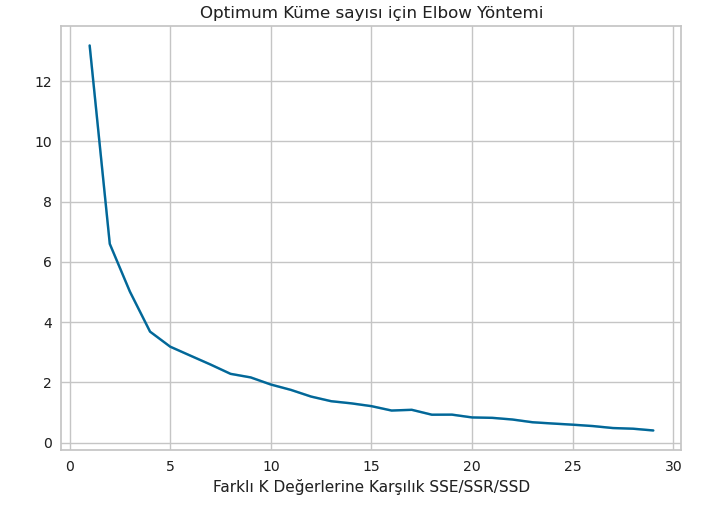

Küme sayısı arttıkça SSD değerleri düşmüş. 10 -15 SSE daha optimum görünüyor.Eğimin en şiddetli olduğu noktalar seçilir. 

In [ ]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df)
elbow.show()

elbow.elbow_value_

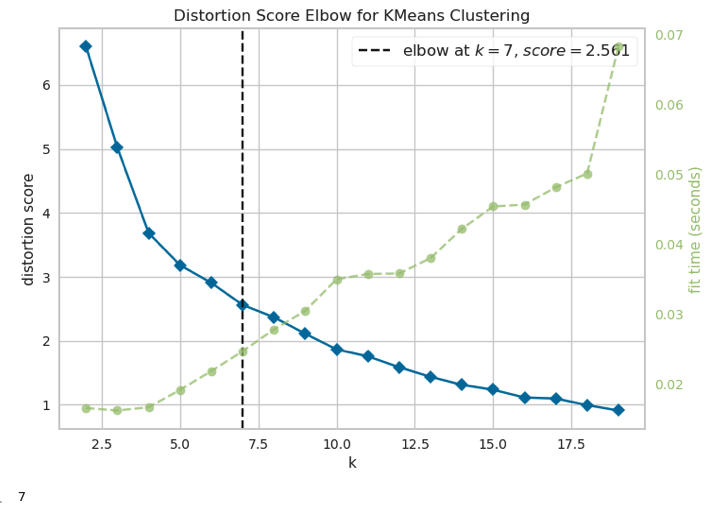

In [22]:
################################
# Final Cluster'ların Oluşturulması
################################

kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df)

kmeans.n_clusters
kmeans.cluster_centers_
kmeans.labels_  #etiketlerim 
df[0:5] #eyaletlerim

clusters_kmeans = kmeans.labels_  #lablellar

df = pd.read_csv("/kaggle/input/usarrests/USArrests.csv", index_col=0)

df["cluster"] = clusters_kmeans  #labelları df e ekle

df.head()

df["cluster"] = df["cluster"] + 1 # 0 dan kutrulduk

df[df["cluster"]==5] # 5 num clasterdan kimler var?

df.groupby("cluster").agg(["count","mean","median"])

df.to_csv("clusters.csv")


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Murder,Assault,UrbanPop,Rape,cluster
Alabama,13.2,236,58,21.2,4
Alaska,10.0,263,48,44.5,6
Arizona,8.1,294,80,31.0,1
Arkansas,8.8,190,50,19.5,3
California,9.0,276,91,40.6,6


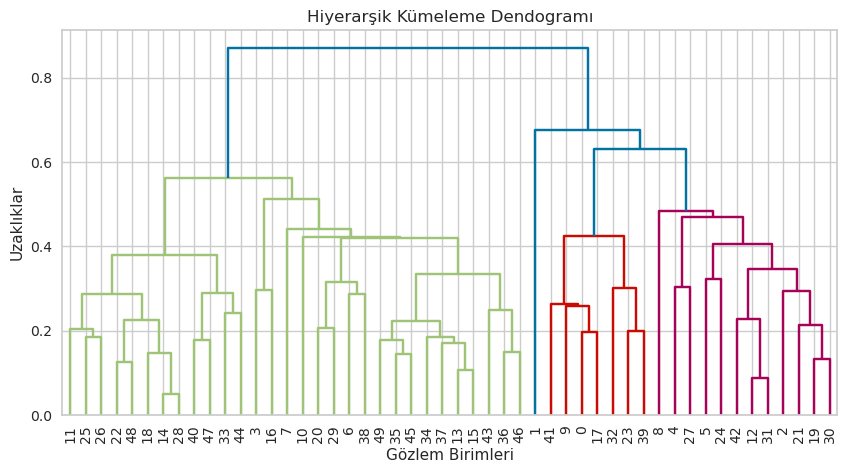

In [23]:
# Hierarchical Clustering
################################

df = pd.read_csv("/kaggle/input/usarrests/USArrests.csv", index_col=0) #oku
#uzaklık temelli olduğu için standartlaştır
sc = MinMaxScaler((0, 1))
df = sc.fit_transform(df)
#öklid uzaklığına göre birleştirici biçimde kümeleme yapar.
hc_average = linkage(df, "average")

plt.figure(figsize=(10, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           leaf_font_size=10)
plt.show()


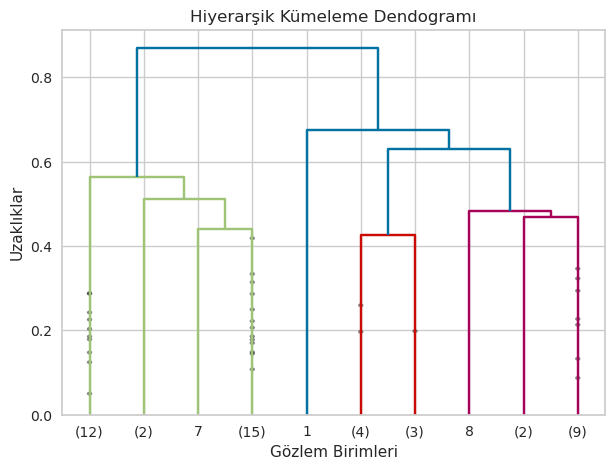

In [24]:

plt.figure(figsize=(7, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

In [ ]:
################################
# Kume Sayısını Belirlemek
################################


plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_average)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axhline(y=0.6, color='b', linestyle='--')
plt.show

In [ ]:
################################
# Final Modeli Oluşturmak
################################

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, linkage="average")

clusters = cluster.fit_predict(df)

df = pd.read_csv("/kaggle/input/usarrests/USArrests.csv", index_col=0)
df["hi_cluster_no"] = clusters

df["hi_cluster_no"] = df["hi_cluster_no"] + 1

df["kmeans_cluster_no"] = df["kmeans_cluster_no"]  + 1
df["kmeans_cluster_no"] = clusters_kmeans

In [4]:
################################
# Principal Component Analysis
################################

df = pd.read_csv("/kaggle/input/hitters-baseball-data/Hitters.csv")
df.head()
#salary ve kategorik değişkenlerle ilgilenmiyorum. 
num_cols = [col for col in df.columns if df[col].dtypes != "O" and "Salary" not in col]

df[num_cols].head()

df = df[num_cols] #sadece sayısal değişkenler kaldı 
df.dropna(inplace=True) #eksik değerler gider
df.shape #(322,16)
#Amacım bu 16 değişkeni, gözlem birimini 2 veya 3 gibi bir sayıya indirmek.
df = StandardScaler().fit_transform(df) #standartlaştırma

pca = PCA() #model nesnesi
pca_fit = pca.fit_transform(df) 

pca.explained_variance_ratio_ #yeni değişkenlerin başarısı varyans=bilgi oranıdır. 
np.cumsum(pca.explained_variance_ratio_)#cumulatif varyans açıklayalım yani peş peşe 2 veya 3 bileşenin varyansı nedir


array([0.46037855, 0.72077704, 0.82416565, 0.87785586, 0.91993427,
       0.94957018, 0.96527809, 0.9766709 , 0.9845032 , 0.9903799 ,
       0.99412755, 0.99722139, 0.99877819, 0.99963722, 0.99992409,
       1.        ])

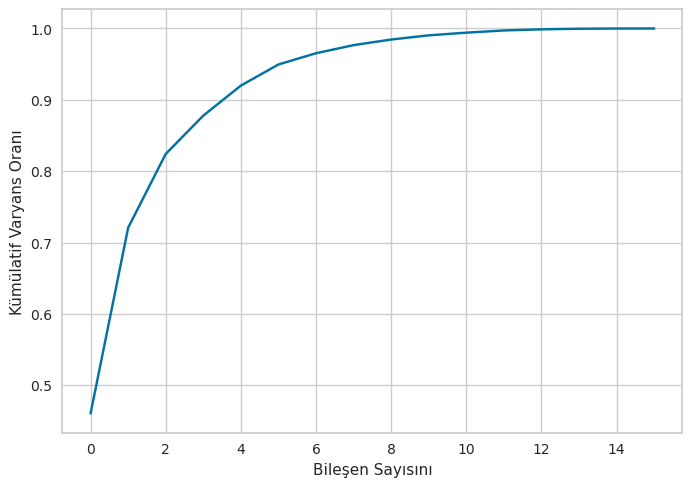

In [5]:
################################
# Optimum Bileşen Sayısı
################################

pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Bileşen Sayısını")
plt.ylabel("Kümülatif Varyans Oranı")
plt.show()
#grafiğimle eğim yerine bakıyorum. 

In [ ]:
################################
# Final PCA'in Oluşturulması
################################
 #yukarıda 3 ü seçtiğimi düşünelim.
pca = PCA(n_components=3)
pca_fit = pca.fit_transform(df)

pca.explained_variance_ratio_
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
################################
# BONUS: Principal Component Regression
################################

df = pd.read_csv("/kaggle/input/hitters-baseball-data/Hitters.csv")
df.shape

len(pca_fit)

num_cols = [col for col in df.columns if df[col].dtypes != "O" and "Salary" not in col]
len(num_cols)

others = [col for col in df.columns if col not in num_cols]

pd.DataFrame(pca_fit, columns=["PC1","PC2","PC3"]).head()

df[others].head()

final_df = pd.concat([pd.DataFrame(pca_fit, columns=["PC1","PC2","PC3"]),
                      df[others]], axis=1)
final_df.head()


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in ["NewLeague", "Division", "League"]:
    label_encoder(final_df, col)

final_df.dropna(inplace=True)

y = final_df["Salary"]
X = final_df.drop(["Salary"], axis=1)

lm = LinearRegression()
rmse = np.mean(np.sqrt(-cross_val_score(lm, X, y, cv=5, scoring="neg_mean_squared_error")))
y.mean()


cart = DecisionTreeRegressor()
rmse = np.mean(np.sqrt(-cross_val_score(cart, X, y, cv=5, scoring="neg_mean_squared_error")))

cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

# GridSearchCV
cart_best_grid = GridSearchCV(cart,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=True).fit(X, y)

cart_final = DecisionTreeRegressor(**cart_best_grid.best_params_, random_state=17).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(cart_final, X, y, cv=5, scoring="neg_mean_squared_error")))